In [1]:
!pip install gcm-filters -q

In [2]:
!pip install gsw -q

In [3]:
!pip install numpy_groupies -q

In [4]:
!pip install xrft --upgrade -q

In [5]:
!pip install sklearn_xarray --upgrade -q

# Dask start

In [6]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46863")

# Import

In [7]:
import sys
sys.path.insert(1, '..')

In [8]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
from scipy import ndimage
from numpy.polynomial import polynomial as P
import xrft
#import xrft_module
import xesmf as xe
import xgcm

In [9]:
import sklearn.linear_model
from sklearn.pipeline import make_pipeline, make_union

from sklearn_xarray import wrap
from sklearn.preprocessing import StandardScaler

In [10]:
# import importlib
# importlib.reload(xrft)

# Plotting params

In [11]:
#%matplotlib widget
%matplotlib inline

In [12]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [13]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds']

# Load data

Choose cases

In [14]:
data=[dict() for i in range(6)]

In [15]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR wint'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR sum'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'AÇORES wint'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'AÇORES sum'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED wint'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED sum'})

## eNATL60

In [16]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [17]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,100),y=y_slice,x=x_slice) 
coord_slice = dict(y=y_slice,x=x_slice)

In [18]:
nb_of_time_chunks = 4

In [19]:
%%time
for i in range(len(data)) :
    #current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set.load()
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set['x'] = np.arange(len(current_set['x']))
    current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR'] = current_set

CPU times: user 3.05 s, sys: 1.2 s, total: 4.25 s
Wall time: 57.3 s


Metrics:

In [20]:
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('X', 'Y',): ['area_t', 'area_u', 'area_v', 'area_f'] # Areas 
}

In [21]:
%%capture --no-display
for i in range(len(data)) :
    data[i]['HR'] = xgcm.autogenerate.generate_grid_ds(data[i]['HR'], axes_dims_dict={'X' : 'x', 'Y' : 'y'}, position=('center', 'right'))
    data[i]['HR'] = xgcm.autogenerate.generate_grid_ds(data[i]['HR'], axes_dims_dict={'X' : 'x', 'Y' : 'y'}, axes_coords_dict={'X' : 'lon', 'Y' : 'lat'}, position=('center', 'outer'))
    data[i]['HR'] = data[i]['HR'].rename({'x_outer': 'x_b','y_outer': 'y_b', 'x_right' : 'x_r', 'y_right' : 'y_r'})
    data[i]['HR'].coords['mask'] = data[i]['HR']['tmask']
    data[i]['HR'].coords['area_t'] = data[i]['HR']['e1t']*data[i]['HR']['e2t']
    data[i]['HR'].coords['area_u'] = data[i]['HR']['e1u']*data[i]['HR']['e2u']
    data[i]['HR'].coords['area_v'] = data[i]['HR']['e1v']*data[i]['HR']['e2v']
    data[i]['HR'].coords['area_f'] = data[i]['HR']['e1f']*data[i]['HR']['e2f']
    data[i]['grid_HR'] = xgcm.Grid(data[i]['HR'], metrics=metrics, periodic=False, \
                                   coords={'X' : {'center' : 'x', 'outer' : 'x_b', 'right' : 'x_r'}, \
                                           'Y' : {'center' : 'y', 'outer' : 'y_b', 'right' : 'y_r'}})
    data[i]['HR'].coords['lon_b'] = data[i]['grid_HR'].interp(da=data[i]['HR']['lon_outer'], axis='Y', to='outer',boundary='extend')
    data[i]['HR'].coords['lat_b'] = data[i]['grid_HR'].interp(da=data[i]['HR']['lat_outer'], axis='X', to='outer',boundary='extend')

## eORCA025

In [22]:
%%time
for i in range(len(data)) :
    data[i]['LR'] = xr.open_mfdataset("../Data/eORCA025/region"+data[i]['region']+"_"+data[i]['season']+".nc", \
                                          chunks={'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    rename(nav_lat='lat', nav_lon='lon')

CPU times: user 172 ms, sys: 6.31 ms, total: 178 ms
Wall time: 185 ms


In [23]:
metrics = {
    ('X',): ['e1t'], # X distances
    ('Y',): ['e2t'], # Y distances
    ('X', 'Y',): ['area_t'] # Areas 
}

In [24]:
%%capture --no-display
for i in range(len(data)) :
    data[i]['LR'] = xgcm.autogenerate.generate_grid_ds(data[i]['LR'], axes_dims_dict={'X' : 'x', 'Y' : 'y'}, position=('center', 'right'))
    data[i]['LR'] = xgcm.autogenerate.generate_grid_ds(data[i]['LR'], axes_dims_dict={'X' : 'x', 'Y' : 'y'}, axes_coords_dict={'X' : 'lon', 'Y' : 'lat'}, position=('center', 'outer'))
    data[i]['LR'] = data[i]['LR'].rename({'x_outer': 'x_b','y_outer': 'y_b', 'x_right' : 'x_r', 'y_right' : 'y_r'})
    data[i]['LR'].coords['mask'] = data[i]['LR']['tmask']
    data[i]['LR'].coords['area_t'] = data[i]['LR']['e1t']*data[i]['LR']['e2t']
    data[i]['grid_LR'] = xgcm.Grid(data[i]['LR'], metrics=metrics, periodic=False, \
                                   coords={'X' : {'center' : 'x', 'outer' : 'x_b', 'right' : 'x_r'}, \
                                           'Y' : {'center' : 'y', 'outer' : 'y_b', 'right' : 'y_r'}})
    data[i]['LR'].coords['lon_b'] = data[i]['grid_LR'].interp(da=data[i]['LR']['lon_outer'], axis='Y', to='outer',boundary='extend')
    data[i]['LR'].coords['lat_b'] = data[i]['grid_LR'].interp(da=data[i]['LR']['lat_outer'], axis='X', to='outer',boundary='extend')

# "True" density

Compute conservative temperature and density anomaly $\sigma_0$ with the use of `gsw` library:

In [25]:
%%time
for i in range(len(data)) :
    for dataKey in ['HR', 'LR'] :
        # density anomaly (sigma0). denoted as 'true' since is computed on the basis of original (non-filtered) HR data
        data[i][dataKey]['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, data[i][dataKey]['sosaline'], data[i][dataKey]['sosstsst'], dask='parallelized').compute()
        # sqr of conservative temperature (to compute the subgrid variance further)
        data[i][dataKey]['sst_sqr'] = data[i][dataKey]['sosstsst']**2
        data[i][dataKey]['sal_sqr'] = data[i][dataKey]['sosaline']**2

CPU times: user 1.2 s, sys: 1.29 s, total: 2.49 s
Wall time: 5.05 s


# Coarsening with the regridder

In [26]:
metrics = {
    ('X',): ['e1t'], # X distances
    ('Y',): ['e2t'], # Y distances
    ('X', 'Y',): ['area_t'] # Areas 
}

In [27]:
%%time
for i in range(len(data)) :
    # regrid
    regridder_with_mask = xe.Regridder(data[i]['HR'], data[i]['LR'], method="conservative_normed")
    data[i]['HR_Coarse'] = regridder_with_mask(data[i]['HR']).drop(['lon_b', 'lat_b', 'x_r', 'y_r', 'x_b', 'y_b'])
    # metrics
    data[i]['HR_Coarse'].coords['e1t'] = (['y','x'], data[i]['LR']['e1t'].values)
    data[i]['HR_Coarse'].coords['e2t'] = (['y','x'], data[i]['LR']['e2t'].values)
    data[i]['HR_Coarse'].coords['area_t'] = data[i]['HR_Coarse'].coords['e1t']*data[i]['HR_Coarse'].coords['e2t']
    data[i]['HR_Coarse'] = xgcm.autogenerate.generate_grid_ds(data[i]['HR_Coarse'], axes_dims_dict={'X' : 'x', 'Y' : 'y'}, position=('center', 'right')) 
    data[i]['grid_HR_Coarse'] = xgcm.Grid(data[i]['HR_Coarse'], metrics=metrics, periodic=False, \
                                   coords={'X' : {'center' : 'x', 'right' : 'x_right'}, \
                                           'Y' : {'center' : 'y', 'right' : 'y_right'}})

CPU times: user 1min 5s, sys: 952 ms, total: 1min 5s
Wall time: 1min 9s


CPU times: user 1.86 s, sys: 226 ms, total: 2.09 s
Wall time: 3.05 s


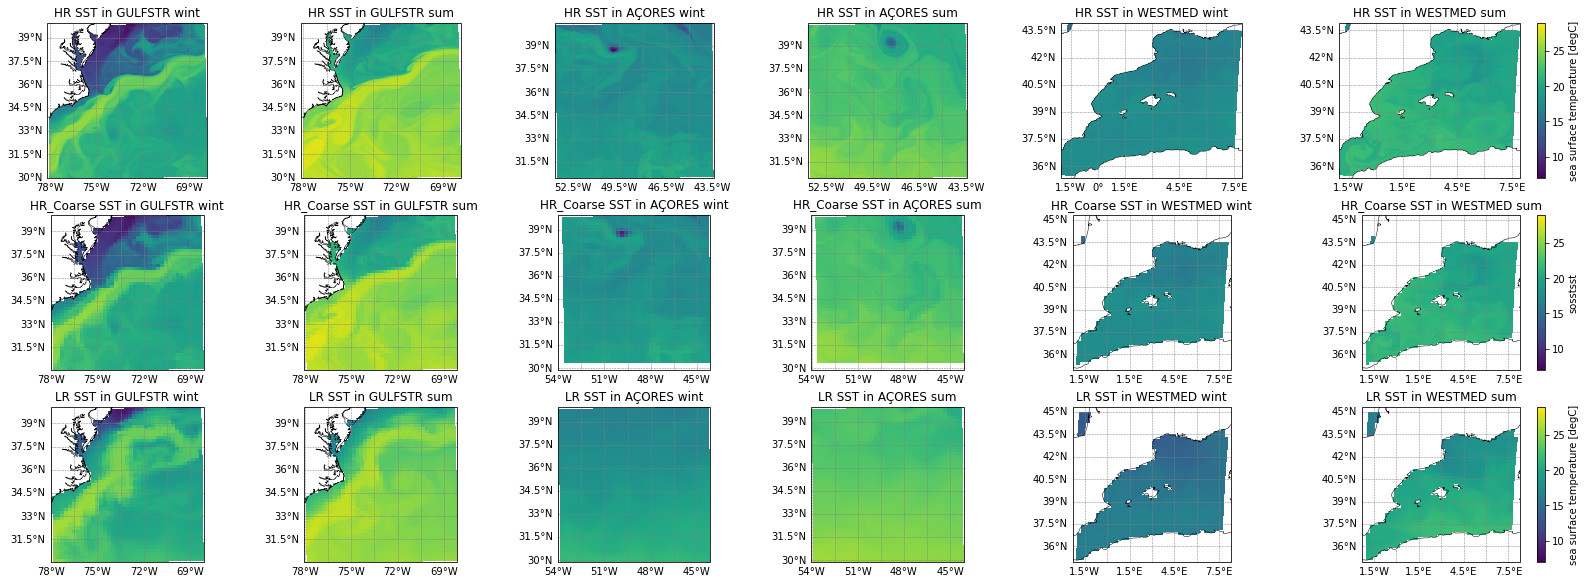

In [28]:
%%time
fig, axis = plt.subplots(ncols=len(data), nrows=3, figsize=(22,8), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True) 
for col in range(len(data)) :
    for row, dataSetKey in enumerate(['HR', 'HR_Coarse', 'LR']) :
        data[col][dataSetKey].isel(time_counter=-1).sosstsst[coord_slice].plot(x='lon', y='lat', ax=axis[row,col], vmin=7, vmax=29, add_colorbar=(col==len(data)-1))
        axis[row,col].set(title=dataSetKey + ' SST in ' + data[col]['label'])

for ax in axis.flatten() :
    ax.coastlines(color='k', lw=0.5)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

# Compute the subgrid variance and density error

Subgrid variance for temperature and salinity is computed as:
$$ \sigma_T^2 = \overline{T^2} -  \overline{T}^2 $$
$$ \sigma_S^2 = \overline{S^2} - \overline{S}^2 $$

The density error is computed as differene between the density obtained by filtering the HR density and the one evaluated on the basis of filtered temperature and salinity:
$$ \Delta \rho =  \overline{\rho(T,S)} - \rho(\overline{T}, \overline{S}) $$

In [29]:
# density after filtering
for ds in [data[i]['HR_Coarse'] for i in range(len(data))] + [data[i]['LR'] for i in range(len(data))]  :
    ds['sigma0_model'] = xr.apply_ufunc(gsw.density.sigma0, ds['sosaline'], ds['sosstsst'], dask='parallelized').compute()

In [30]:
%%time
for ds in [data[i]['HR_Coarse'] for i in range(len(data))] :
    # subgrid temp variance
    ds['var_T'] = ds['sst_sqr'] - ds['sosstsst']**2
    ds['var_S'] = ds['sal_sqr'] - ds['sosaline']**2
    # density correction
    ds['sigma0_delta'] = ds['sigma0_true'] - ds['sigma0_model']

CPU times: user 76.6 ms, sys: 2.95 ms, total: 79.6 ms
Wall time: 76.5 ms


CPU times: user 350 ms, sys: 22 ms, total: 372 ms
Wall time: 416 ms


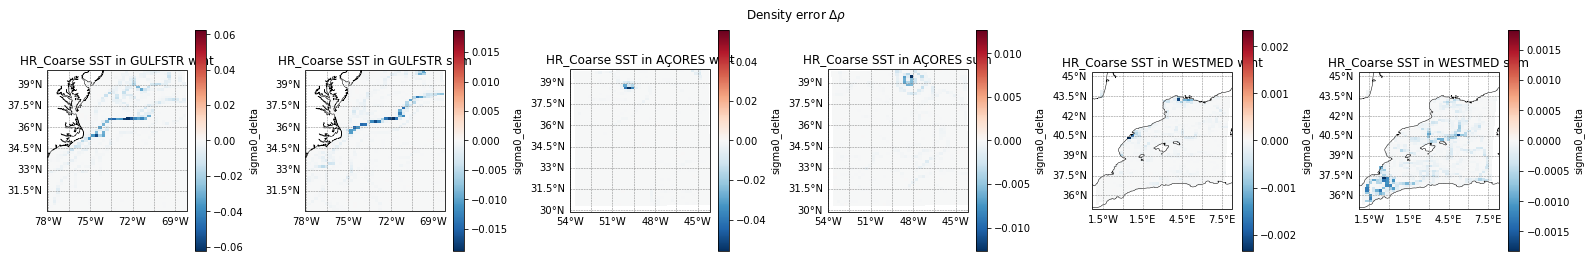

In [31]:
%%time
fig, axis = plt.subplots(ncols=len(data), nrows=1, figsize=(22,3.5), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True, squeeze=False) 
fig.suptitle(r'Density error $\Delta \rho$')
for col in range(len(data)) :
    for row, dataSetKey in enumerate(['HR_Coarse']) :
        data[col][dataSetKey].isel(time_counter=-1).sigma0_delta[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])#, add_colorbar=(col==len(data)-1))
        axis[row,col].set(title=dataSetKey + ' SST in ' + data[col]['label'])

for ax in axis.flatten() :
    ax.coastlines(color='k', lw=0.5)
    ax.set(ylabel='')
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

# Spatial derivatives

In [37]:
for dataSetKey in ['HR_Coarse'] :
    for i in range(len(data)) :
        grid = data[i]['grid_'+dataSetKey]
        for var in ['sosstsst', 'sosaline', 'sigma0_delta', 'var_T'] :
            data[i][dataSetKey]['diff_'+var+'_sqr'] = grid.interp(grid.diff(data[i][dataSetKey][var], 'X', boundary='extend')**2, 'X') + \
                                       grid.interp(grid.diff(data[i][dataSetKey][var], 'Y', boundary='extend')**2, 'Y')

# Spatial correlation between gradients

In [46]:
# initialize data structure for storing histograms
cors=[dict() for i in range(len(data))]
for i in range(len(data)) :
    cors[i]['HR_Coarse'] = dict({'label' : 'eNATL60 Coarse'})
    cors[i]['HR'] = dict({'label' : 'eNATL60'})
    cors[i]['LR'] = dict({'label' : 'eORCA025'})

In [91]:
%%time
for i in range(len(data)) :
    cors[i]['HR_Coarse']['corr_error_vs_var_T_diff'] = xr.corr(data[i]['HR_Coarse']['diff_var_T_sqr'], \
                                                               data[i]['HR_Coarse']['diff_sigma0_delta_sqr'], dim=['x', 'y']).compute()
    cors[i]['HR_Coarse']['corr_error_vs_var_T'] = xr.corr(data[i]['HR_Coarse']['var_T'], \
                                                               data[i]['HR_Coarse']['sigma0_delta'], dim=['x', 'y']).compute()

CPU times: user 1.64 s, sys: 156 ms, total: 1.8 s
Wall time: 5.74 s


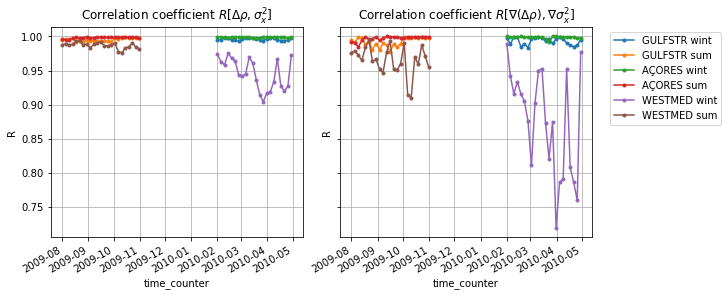

In [93]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4), sharey=True) 
for i in range(len(data)) :
    (-cors[i]['HR_Coarse']['corr_error_vs_var_T']).plot(ax=ax[0], ls='-', marker='.', color=line_colors[i], label=data[i]['label'])
    cors[i]['HR_Coarse']['corr_error_vs_var_T_diff'].plot(ax=ax[1], ls='-', marker='.', color=line_colors[i], label=data[i]['label'])
ax[0].set(title=r'Correlation coefficient $R[\Delta \rho, \sigma_x^2 ]$', ylabel='R'); ax[0].grid(True) 
ax[1].set(title=r'Correlation coefficient $R[\nabla (\Delta \rho), \nabla \sigma_x^2 ]$', ylabel='R'); ax[1].grid(True)    
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Predictor in deterministic parametrization

Compute the second derivatives of the density with the respect to temperature and salinity (known from the EOS)

In [63]:
%%time
for ds in [data[i]['HR_Coarse'] for i in range(len(data))] :
    ds['rho_sa_sa'], ds['rho_sa_ct'], ds['rho_ct_ct'] = eos_module.rho_second_derivatives(ds['sosaline'], ds['sosstsst'])

CPU times: user 2.59 s, sys: 5.15 ms, total: 2.6 s
Wall time: 2.59 s


In [77]:
%%time
for i in range(len(data)) :
    grid = data[i]['grid_'+dataSetKey]
    data[i]['HR_Coarse']['predictor_T'] = data[i]['HR_Coarse']['rho_ct_ct']*data[i]['HR_Coarse']['diff_sosstsst_sqr']
    data[i]['HR_Coarse']['diff_predictor_T_sqr'] = grid.interp(grid.diff(data[i]['HR_Coarse']['predictor_T'], 'X', boundary='extend')**2, 'X') + \
                                 grid.interp(grid.diff(data[i]['HR_Coarse']['predictor_T'], 'Y', boundary='extend')**2, 'Y')

CPU times: user 478 ms, sys: 3.93 ms, total: 482 ms
Wall time: 476 ms


CPU times: user 988 ms, sys: 43.5 ms, total: 1.03 s
Wall time: 2.53 s


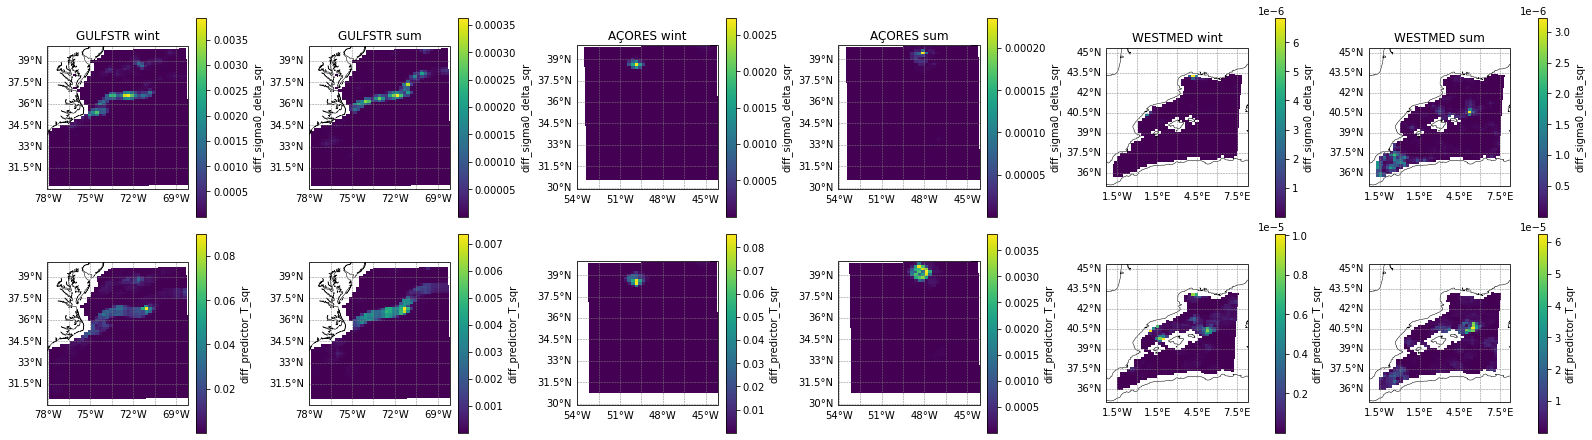

In [83]:
%%time
fig, axis = plt.subplots(ncols=len(data), nrows=2, figsize=(22,6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True) 
for col in range(len(data)) :
    for row, varKey in enumerate(['diff_sigma0_delta_sqr', 'diff_predictor_T_sqr']) :
        data[col]['HR_Coarse'][varKey].isel(time_counter=-1)[coord_slice].plot(x='lon', y='lat', ax=axis[row,col]) #,vmin=7, vmax=29, add_colorbar=(col==len(data)-1))
        axis[row,col].set(title=data[col]['label'] if row==0 else '')
        axis[row,col].set(ylabel=varKey if col==0 else '')
        
for ax in axis.flatten() :
    ax.coastlines(color='k', lw=0.5)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

In [87]:
%%time
for i in range(len(data)) :
    cors[i]['HR_Coarse']['corr_error_vs_predictor_T_diff'] = xr.corr(data[i]['HR_Coarse']['diff_predictor_T_sqr'], \
                                                               data[i]['HR_Coarse']['diff_sigma0_delta_sqr'], dim=['x', 'y']).compute()
    cors[i]['HR_Coarse']['corr_error_vs_predictor_T'] = xr.corr(data[i]['HR_Coarse']['predictor_T'], \
                                                               data[i]['HR_Coarse']['sigma0_delta'], dim=['x', 'y']).compute()

CPU times: user 2.52 s, sys: 259 ms, total: 2.78 s
Wall time: 9 s


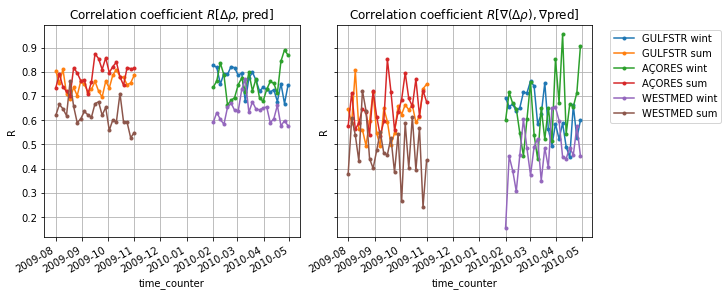

In [89]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4), sharey=True) 
for i in range(len(data)) :
    cors[i]['HR_Coarse']['corr_error_vs_predictor_T'].plot(ax=ax[0], ls='-', marker='.', color=line_colors[i], label=data[i]['label'])
    cors[i]['HR_Coarse']['corr_error_vs_predictor_T_diff'].plot(ax=ax[1], ls='-', marker='.', color=line_colors[i], label=data[i]['label'])
ax[0].set(title=r'Correlation coefficient $R[\Delta \rho, \rm{pred} ]$', ylabel='R'); ax[0].grid(True)    
ax[1].set(title=r'Correlation coefficient $R[\nabla (\Delta \rho), \nabla \rm{pred} ]$', ylabel='R'); ax[1].grid(True)    
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()